# Regressing Clinical Measures from Video Data in Telepresence Interactions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
import sklearn
import sklearn.linear_model as linr
import sklearn.model_selection as model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.ensemble as ensemble
import sklearn.tree as tree
import numpy as np

%matplotlib inline 

In [2]:
def fix_reps(results):
    subj_store=9999
    rep_count_left=0
    rep_count_right=0
    for idx in range(len(results)):
        subj=results.loc[idx,'subject']
        if not subj_store==subj:
            subj_store=subj
            rep_count_left=0
            rep_count_right=0
        side = results.loc[idx, 'side']
        if side=='right':
            results.loc[idx, 'rep']=rep_count_right
            rep_count_right += 1
        if side=='left':
            results.loc[idx, 'rep']=rep_count_left
            rep_count_left += 1    

## Simon Says (Reachable Workspace)

In [3]:
target_dir=pathlib.Path("/media/mjsobrep/43CDA61E672B9161/pose/")
results_ss=pd.read_csv(target_dir/"ss_ch.csv")

In [4]:
results_ss.replace(['R','L'],['right','left'],inplace=True)
fix_reps(results_ss)
print(results_ss.to_string())

    Unnamed: 0  subject  rep   side        bbt  age   convex_hull   arm_length  norm_convex_hull
0            0       23    0  right  -2.561644    4  3.142130e+07   276.305789          0.355603
1            1       23    0   left  -1.034091    4  2.778608e+07   273.391793          0.324625
2            2       23    1  right  -2.561644    4  3.938454e+08  1400.678772          0.034215
3            3       23    1   left  -1.034091    4  3.656176e+08   940.832840          0.104810
4            4       44    0  right -10.169811    7  1.488394e+07   433.546605          0.043604
5            5       44    0   left  -3.071429    7  1.250872e+08   411.600966          0.428248
6            6       44    1  right -10.169811    7  1.294636e+07   432.532581          0.038195
7            7       44    1   left  -3.071429    7  1.222304e+08   415.201379          0.407675
8            8       15    0  right   0.507463    5  7.657251e+08   438.310997          2.170887
9            9       15    0  

In [5]:
results_ss['convex_hull'].max()/results_ss['convex_hull'].median()

682.3968869933886

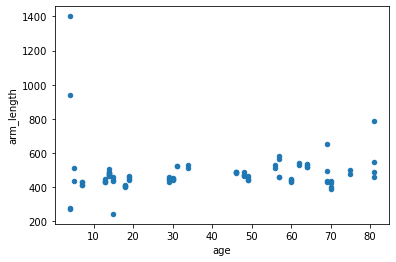

In [6]:
results_ss.plot("age", "arm_length", "scatter")

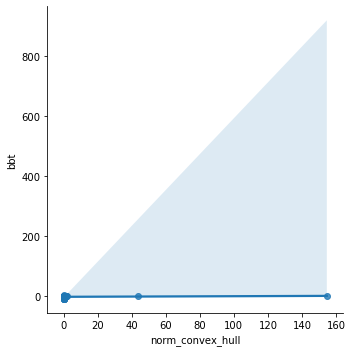

In [7]:
sns.lmplot(x='norm_convex_hull',y='bbt',data=results_ss,fit_reg=True) 

(-8, 5)

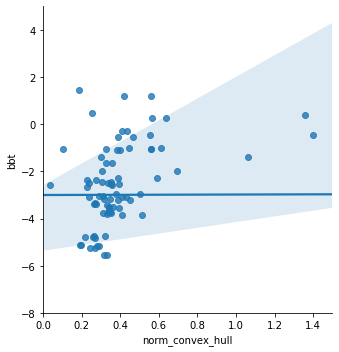

In [32]:
sns.lmplot(x='norm_convex_hull',y='bbt',data=results_ss,fit_reg=True) 
plt.xlim([0, 1.5])
plt.ylim([-8,5])

In [8]:
bbt_vals=results_ss['bbt'].values.reshape(-1,1)
ch_vals=results_ss['norm_convex_hull'].values.reshape(-1,1)

In [9]:
reg=linr.LinearRegression().fit(ch_vals,bbt_vals)
print(f'bbt z-score={reg.coef_}*norm_convex_hull + {reg.intercept_} || R^2={reg.score(ch_vals,bbt_vals)}')

bbt z-score=[[0.01997192]]*norm_convex_hull + [-2.99946742] || R^2=0.019345634032068126


In [10]:
lm = linr.LinearRegression()
cv = model_selection.LeaveOneOut().split(results_ss) # leave one out doesn't work for linear regression with r^2
scores = model_selection.cross_val_score(lm,  ch_vals,bbt_vals, scoring='neg_mean_absolute_error', cv=cv)
print(f'MAE: {np.mean(np.absolute(scores))}, median absolute error: {np.median(np.absolute(scores))}')

MAE: 1.8119292423658215, median absolute error: 1.474844769294441


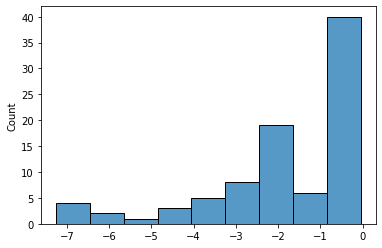

In [11]:
sns.histplot(scores)

Pretty bad performance. Outliers aren't helping. Let's try RANSAC

In [12]:
lm = linr.RANSACRegressor()
cv = model_selection.LeaveOneOut().split(results_ss) # leave one out doesn't work for linear regression with r^2
scores = model_selection.cross_val_score(lm,  ch_vals,bbt_vals, scoring='neg_mean_absolute_error', cv=cv)
print(f'MAE: {np.mean(np.absolute(scores))}, median absolute error: {np.median(np.absolute(scores))}')

MAE: 16.35696042448213, median absolute error: 1.4442422949372518


In [25]:
try_models(ch_vals, bbt_vals,['ch'])

model: elasticnet, MAE: 5.405995766448443, median absolute error: 1.8359984438313934
model: ridge, MAE: 11.0278201236084, median absolute error: 1.830354409132232
model: lasso, MAE: 3.3844725191367346, median absolute error: 1.8359984438313934
model: ransacregressor, MAE: 29.162965584845075, median absolute error: 1.5797023526028402
model: adaboost, MAE: 1.578464473167716, median absolute error: 1.0334707591224226
model: gradientboost, MAE: 1.7166863443718061, median absolute error: 1.058777574078001


,model,ch
0,elasticnet,0.0
0,ridge,0.33424730444418427
0,lasso,0.0


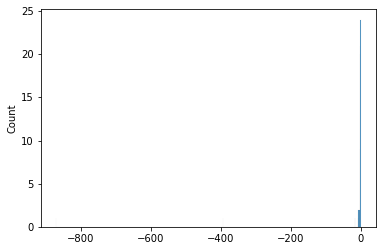

In [13]:
sns.histplot(scores)

(-10, 10)

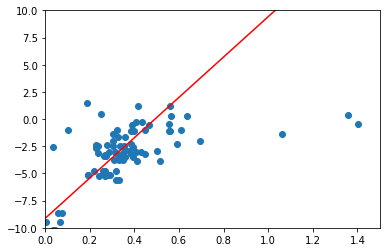

In [34]:
plt.scatter(ch_vals, bbt_vals)
lm.fit(ch_vals, bbt_vals)
xaxis = np.array([ch_vals.min(), ch_vals.max()])
yaxis = lm.predict(xaxis.reshape((len(xaxis), 1)))
plt.plot(xaxis,yaxis,'r')
plt.xlim([0, 1.5])
plt.ylim([-10,10])

MAE is worse with RANSAC, but the fit is obviously better. MAE might not be the best measure...

## Target Touch (Kinematics)

In [15]:
results_tt=pd.read_csv(target_dir/"tt_features.csv")
fix_reps(results_tt)
results_tt

,Unnamed: 0,subject,rep,side,bbt,age,max_acceleration,max_acceleration_over_avg_acceleration,time_to_max_acceleration,time_to_max_acceleration_normalized,max_velocity,time_to_max_velocity,time_to_max_velocity_normalized,max_velocity_over_avg_velocity,distance_traveled,movement_time_length,number_movements
0,0,23,0,right,-2.561644,4,3906.580363,1.843786,0.235194,0.269242,761.862490,0.335945,0.523804,1.685209,291.960020,0.671871,33
1,1,23,0,left,-1.034091,4,3953.494032,1.819340,0.436747,0.755953,942.022324,0.352740,0.532737,1.625997,346.562807,0.722285,24
2,2,23,1,right,-2.561644,4,5041.901007,1.846875,0.285380,0.488109,798.623359,0.319161,0.499998,1.628771,278.396045,0.604745,42
3,3,23,1,left,-1.034091,4,4250.915057,1.890743,0.437788,0.849384,837.528316,0.419415,0.571428,1.570988,352.303603,0.705058,32
4,4,44,0,right,-10.169811,7,381.506370,2.138178,1.075085,0.954546,271.463669,1.175685,0.538464,1.301271,377.844806,2.116419,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,80,20,1,left,-1.972973,81,3417.245365,1.639307,0.386365,0.469269,744.377258,0.302371,0.464296,1.716933,345.252402,0.755517,16
81,81,35,0,right,-1.085714,70,3914.391168,1.705505,0.134383,0.190474,749.805682,0.302382,0.499543,1.632413,288.498924,0.636641,17
82,82,35,0,left,-3.042857,70,3085.014781,1.738629,0.436469,0.772739,727.919043,0.369559,0.533342,1.569342,289.590901,0.721842,18
83,83,35,1,right,-1.085714,70,4333.035554,1.733531,0.436755,0.789474,763.451009,0.335963,0.518520,1.570333,288.103724,0.571134,15


In [16]:
feature_names=['age', 'max_acceleration', 'max_acceleration_over_avg_acceleration', 'time_to_max_acceleration','time_to_max_acceleration_normalized','max_velocity','time_to_max_velocity','time_to_max_velocity_normalized','max_velocity_over_avg_velocity','distance_traveled']
features=results_tt[feature_names]
labels=results_tt[['bbt']]

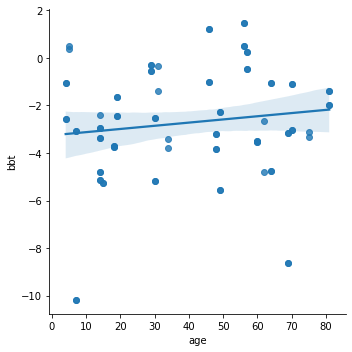

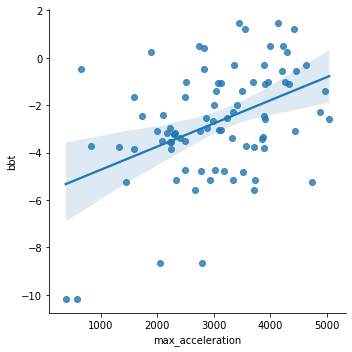

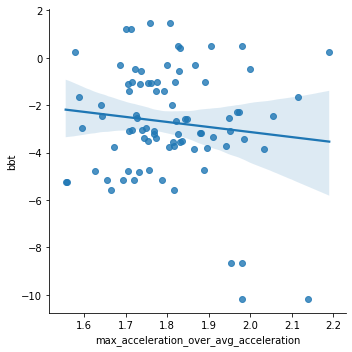

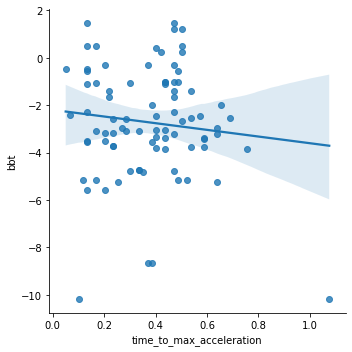

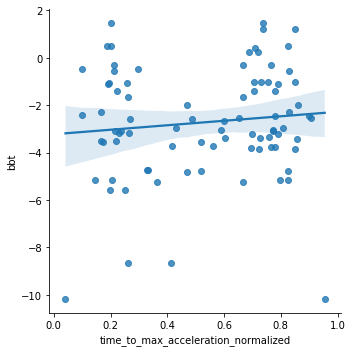

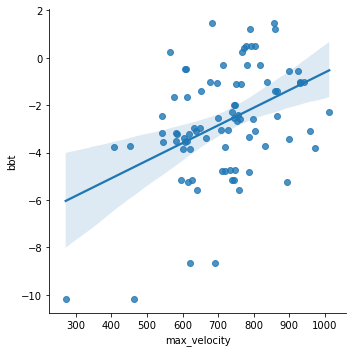

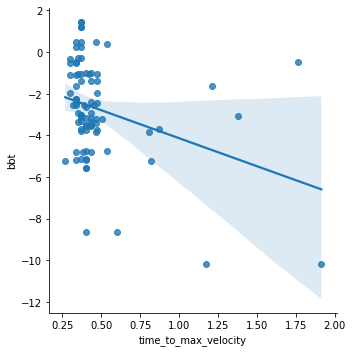

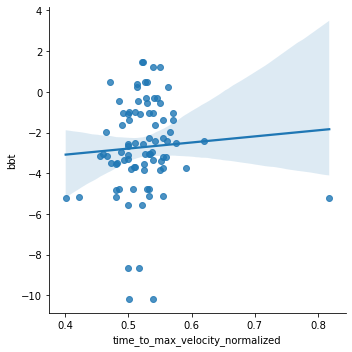

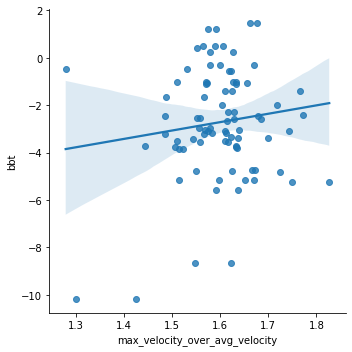

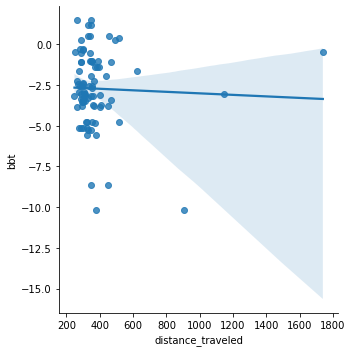

In [17]:
for feature in feature_names:
    sns.lmplot(x=feature,y='bbt',data=results_tt,fit_reg=True) 

In [18]:
def try_models(features,labels, feature_names):
    model_coefs=pd.DataFrame(columns=['model']+feature_names)
    for model_def in [('elasticnet', linr.ElasticNet()),('ridge',linr.Ridge()),
                      ('lasso',linr.Lasso()),('ransacregressor',linr.RANSACRegressor()),
                      ('adaboost',ensemble.AdaBoostRegressor()),
                      ('gradientboost',ensemble.GradientBoostingRegressor()),
                      ('decision_tree',tree.DecisionTreeRegressor())
                     ]:
        lm=model_def[1]
        name=model_def[0]
        pipeline=sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), lm)
        scores = model_selection.cross_validate(pipeline,  features,np.ravel(labels), scoring=('r2','neg_mean_absolute_error','neg_median_absolute_error'), cv=10, return_train_score=False)
        pipeline.fit(features,np.ravel(labels))
        try:
            coefs=pipeline.named_steps[name].coef_
            model_coefs=pd.concat([model_coefs, pd.DataFrame(np.atleast_2d(np.array([name]+list(coefs))),columns=['model']+feature_names)])
        except:
            pass
        print(f'model: {name}, MAE: {np.mean(np.absolute(scores["test_neg_mean_absolute_error"]))}, median absolute error: {np.median(np.absolute(scores["test_neg_median_absolute_error"]))}')

    return model_coefs

try_models(features, labels,feature_names)

model: elasticnet, MAE: 1.736551206249355, median absolute error: 1.3636708750826068
model: ridge, MAE: 1.6644739711327858, median absolute error: 1.2189630841972083
model: lasso, MAE: 1.8092780763596383, median absolute error: 1.273641400796131
model: ransacregressor, MAE: 3.0764792068659523, median absolute error: 1.9916514314137705
model: adaboost, MAE: 1.9096963671632217, median absolute error: 1.6454249513068828
model: gradientboost, MAE: 1.9302733444704088, median absolute error: 1.4102871959401106
model: decision_tree, MAE: 2.8315183988080226, median absolute error: 2.174143600683288


,model,age,max_acceleration,max_acceleration_over_avg_acceleration,time_to_max_acceleration,time_to_max_acceleration_normalized,max_velocity,time_to_max_velocity,time_to_max_velocity_normalized,max_velocity_over_avg_velocity,distance_traveled
0,elasticnet,0.0,0.21252324429458208,-0.0,-0.0,0.0,0.20121006993472138,-0.023597607935613874,0.0,0.0,0.0
0,ridge,0.22493490102229496,0.4418784867353094,-0.15119370390154144,-1.0687426355331933,0.9583076104778008,0.2676540450266232,-1.448489306871756,0.5628000742875502,-0.7273379440491574,1.1432075935707255
0,lasso,0.0,0.0018854077186683288,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0


This is kinda cool. We can see that max_acceleration is the most important feature. Max velocity and time to max velocity are also important. 

Ridge, as expected, uses a bit of everything, probably over fitting, but performs well. Elastic net is the most attractive here.

## All together now

In [19]:
results_all=results_tt.merge(results_ss[['subject','side','rep','norm_convex_hull','convex_hull']], on=['subject','side','rep'])
results_all

,Unnamed: 0,subject,rep,side,bbt,age,max_acceleration,max_acceleration_over_avg_acceleration,time_to_max_acceleration,time_to_max_acceleration_normalized,max_velocity,time_to_max_velocity,time_to_max_velocity_normalized,max_velocity_over_avg_velocity,distance_traveled,movement_time_length,number_movements,norm_convex_hull,convex_hull
0,0,23,0,right,-2.561644,4,3906.580363,1.843786,0.235194,0.269242,761.862490,0.335945,0.523804,1.685209,291.960020,0.671871,33,0.355603,3.142130e+07
1,1,23,0,left,-1.034091,4,3953.494032,1.819340,0.436747,0.755953,942.022324,0.352740,0.532737,1.625997,346.562807,0.722285,24,0.324625,2.778608e+07
2,2,23,1,right,-2.561644,4,5041.901007,1.846875,0.285380,0.488109,798.623359,0.319161,0.499998,1.628771,278.396045,0.604745,42,0.034215,3.938454e+08
3,3,23,1,left,-1.034091,4,4250.915057,1.890743,0.437788,0.849384,837.528316,0.419415,0.571428,1.570988,352.303603,0.705058,32,0.104810,3.656176e+08
4,4,44,0,right,-10.169811,7,381.506370,2.138178,1.075085,0.954546,271.463669,1.175685,0.538464,1.301271,377.844806,2.116419,19,0.043604,1.488394e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,80,20,1,left,-1.972973,81,3417.245365,1.639307,0.386365,0.469269,744.377258,0.302371,0.464296,1.716933,345.252402,0.755517,16,0.306640,6.219274e+08
78,81,35,0,right,-1.085714,70,3914.391168,1.705505,0.134383,0.190474,749.805682,0.302382,0.499543,1.632413,288.498924,0.636641,17,0.400186,1.284149e+08
79,82,35,0,left,-3.042857,70,3085.014781,1.738629,0.436469,0.772739,727.919043,0.369559,0.533342,1.569342,289.590901,0.721842,18,0.288978,7.304128e+07
80,83,35,1,right,-1.085714,70,4333.035554,1.733531,0.436755,0.789474,763.451009,0.335963,0.518520,1.570333,288.103724,0.571134,15,0.385636,1.364190e+08


In [20]:
feature_names_all = feature_names+['norm_convex_hull','convex_hull']
features_all=results_all[feature_names_all]
labels_all=results_all[['bbt']]
try_models(features_all, labels_all, feature_names_all)

model: elasticnet, MAE: 5.725185997275999, median absolute error: 1.5373940943246902
model: ridge, MAE: 9.911979603466879, median absolute error: 1.4410637159104454
model: lasso, MAE: 3.1508016947248976, median absolute error: 1.5555922686700172
model: ransacregressor, MAE: 8.902240983349188, median absolute error: 2.4265680271688668
model: adaboost, MAE: 1.3961839098073825, median absolute error: 1.3681595392867565
model: gradientboost, MAE: 1.423033705805763, median absolute error: 1.283495842658081
model: decision_tree, MAE: 1.88385820858231, median absolute error: 1.4745209373596713


,model,age,max_acceleration,max_acceleration_over_avg_acceleration,time_to_max_acceleration,time_to_max_acceleration_normalized,max_velocity,time_to_max_velocity,time_to_max_velocity_normalized,max_velocity_over_avg_velocity,distance_traveled,norm_convex_hull,convex_hull
0,elasticnet,0.0,0.1890891447857438,-0.0,-0.0,0.0,0.17951380170691833,-0.02408301328819794,0.0,0.0,0.0,0.0,0.0
0,ridge,0.22562389874742425,0.3425464646150623,-0.1872714676616418,-0.9601748298486668,1.0420988577780386,0.3020886303122608,-1.4817627256089783,0.41974499891554484,-0.7683227216801016,1.169894041419905,0.155969703384613,-0.002239325441468729
0,lasso,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0


We can see that with the addition of these last two values, things really go down the drain for the linear models, our weights just end up in the trash, but the boosted models actually get better. Yay boosting!!

## Selecting Features

Clearly the simon says data isn't getting us anywhere, so let's stick to the target touch data. 

In [21]:
feature_names=[ 'max_acceleration','max_velocity','time_to_max_velocity']
features=results_tt[feature_names]
labels=results_tt[['bbt']]
try_models(features, labels,feature_names)

model: elasticnet, MAE: 1.736551204626533, median absolute error: 1.3636708750826068
model: ridge, MAE: 1.8141462956117018, median absolute error: 1.4905619133233703
model: lasso, MAE: 1.8092780763596383, median absolute error: 1.273641400796131
model: ransacregressor, MAE: 2.2035581646498263, median absolute error: 1.9198968975631807
model: adaboost, MAE: 1.9510443271731475, median absolute error: 1.30922823649182
model: gradientboost, MAE: 2.095827546849703, median absolute error: 1.6420886589217312
model: decision_tree, MAE: 2.300691169071796, median absolute error: 1.7933907953486696


,model,max_acceleration,max_velocity,time_to_max_velocity
0,elasticnet,0.21252324429458208,0.20121006993472138,-0.023597607935613874
0,ridge,0.2615084938992804,0.6305921229779166,-0.3231946264207566
0,lasso,0.0018854077186683288,0.0,-0.0


In [22]:
feature_names=[ 'max_acceleration']
features=results_tt[feature_names]
labels=results_tt[['bbt']]
try_models(features, labels,feature_names)

model: elasticnet, MAE: 1.7334603752115907, median absolute error: 1.324821844881431
model: ridge, MAE: 1.7034872708232727, median absolute error: 1.2863609339125268
model: lasso, MAE: 1.8106889414917522, median absolute error: 1.273641400796131
model: ransacregressor, MAE: 1.680649378948964, median absolute error: 1.247513690508184
model: adaboost, MAE: 1.8779113256217177, median absolute error: 1.4665693133054931
model: gradientboost, MAE: 2.1153780303727077, median absolute error: 1.836276130040829
model: decision_tree, MAE: 2.389976813641394, median absolute error: 1.9443163460668196


,model,max_acceleration
0,elasticnet,0.3345902718124456
0,ridge,0.9902355773963587
0,lasso,0.0018854077186683288


Although paring down values doe improve the linear models, it does not improve the boosted models. We will be sticking with the boosted models...

## Classification

Thus far, we have attempted regression. Here we will try classification into 
no-low impairment, mild impairment, moderate impairment, and sever impairment. 

In [23]:
results_all
conditions=[
    (results_all['bbt']>-1),
    (results_all['bbt']<=-1) &(results_all['bbt']>-2),
    (results_all['bbt']<=-2) &(results_all['bbt']>-3),
    (results_all['bbt']<=-3),
]
choices=['no-impaired','mild-impairment','moderate-impairment','severe-impairment']
results_all['impairment']=np.select(conditions,choices)
results_all

,Unnamed: 0,subject,rep,side,bbt,age,max_acceleration,max_acceleration_over_avg_acceleration,time_to_max_acceleration,time_to_max_acceleration_normalized,max_velocity,time_to_max_velocity,time_to_max_velocity_normalized,max_velocity_over_avg_velocity,distance_traveled,movement_time_length,number_movements,norm_convex_hull,convex_hull,impairment
0,0,23,0,right,-2.561644,4,3906.580363,1.843786,0.235194,0.269242,761.862490,0.335945,0.523804,1.685209,291.960020,0.671871,33,0.355603,3.142130e+07,moderate-impairment
1,1,23,0,left,-1.034091,4,3953.494032,1.819340,0.436747,0.755953,942.022324,0.352740,0.532737,1.625997,346.562807,0.722285,24,0.324625,2.778608e+07,mild-impairment
2,2,23,1,right,-2.561644,4,5041.901007,1.846875,0.285380,0.488109,798.623359,0.319161,0.499998,1.628771,278.396045,0.604745,42,0.034215,3.938454e+08,moderate-impairment
3,3,23,1,left,-1.034091,4,4250.915057,1.890743,0.437788,0.849384,837.528316,0.419415,0.571428,1.570988,352.303603,0.705058,32,0.104810,3.656176e+08,mild-impairment
4,4,44,0,right,-10.169811,7,381.506370,2.138178,1.075085,0.954546,271.463669,1.175685,0.538464,1.301271,377.844806,2.116419,19,0.043604,1.488394e+07,severe-impairment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,80,20,1,left,-1.972973,81,3417.245365,1.639307,0.386365,0.469269,744.377258,0.302371,0.464296,1.716933,345.252402,0.755517,16,0.306640,6.219274e+08,mild-impairment
78,81,35,0,right,-1.085714,70,3914.391168,1.705505,0.134383,0.190474,749.805682,0.302382,0.499543,1.632413,288.498924,0.636641,17,0.400186,1.284149e+08,mild-impairment
79,82,35,0,left,-3.042857,70,3085.014781,1.738629,0.436469,0.772739,727.919043,0.369559,0.533342,1.569342,289.590901,0.721842,18,0.288978,7.304128e+07,severe-impairment
80,83,35,1,right,-1.085714,70,4333.035554,1.733531,0.436755,0.789474,763.451009,0.335963,0.518520,1.570333,288.103724,0.571134,15,0.385636,1.364190e+08,mild-impairment


In [24]:
def try_models(features,labels, feature_names):
    model_coefs=pd.DataFrame(columns=['model']+feature_names)
    for model_def in [('elasticnet', linr.ElasticNet()),('ridge',linr.Ridge()),
                      ('lasso',linr.Lasso()),('ransacregressor',linr.RANSACRegressor()),
                      ('adaboost',ensemble.AdaBoostRegressor()),
                      ('gradientboost',ensemble.GradientBoostingRegressor())
                     ]:
        lm=model_def[1]
        name=model_def[0]
        pipeline=sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), lm)
        scores = model_selection.cross_validate(pipeline,  features,np.ravel(labels), scoring=('r2','neg_mean_absolute_error','neg_median_absolute_error'), cv=10, return_train_score=False)
        pipeline.fit(features,np.ravel(labels))
        try:
            coefs=pipeline.named_steps[name].coef_
            model_coefs=pd.concat([model_coefs, pd.DataFrame(np.atleast_2d(np.array([name]+list(coefs))),columns=['model']+feature_names)])
        except:
            pass
        print(f'model: {name}, MAE: {np.mean(np.absolute(scores["test_neg_mean_absolute_error"]))}, median absolute error: {np.median(np.absolute(scores["test_neg_median_absolute_error"]))}')

    return model_coefs

try_models(features, labels,feature_names)

model: elasticnet, MAE: 1.7334603752115907, median absolute error: 1.324821844881431
model: ridge, MAE: 1.7034872708232727, median absolute error: 1.2863609339125268
model: lasso, MAE: 1.8106889414917522, median absolute error: 1.273641400796131
model: ransacregressor, MAE: 1.5148426228493475, median absolute error: 1.311458139245092
model: adaboost, MAE: 1.8868659919422075, median absolute error: 1.5690442609133548
model: gradientboost, MAE: 2.1153780303727077, median absolute error: 1.836276130040829


,model,max_acceleration
0,elasticnet,0.3345902718124456
0,ridge,0.9902355773963587
0,lasso,0.0018854077186683288
